In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import dynamiqs as dq
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
import optax
from jax.typing import ArrayLike

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = 'true'
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = '0.3'

from pulse_optimization import Simulation
import pulses_shapes as ps

In [2]:
MHz = 2 * jnp.pi
kHz = 2 * jnp.pi * 1e-3
us = 1.0
ns = 1.0e-3

In [3]:
Na, Nb = 20, 9

nbar_max = 4
nbar_0 = 4

kappa_a = 1 / (10 * us)
kappa_b = 15 * MHz
g2 = 2 * MHz
ed_max = -nbar_max * g2
gl_max = g2 / 2

t_max = 1 * us
N_tpulse = int(t_max // (10 * ns)) + 1
tpulse = jnp.linspace(0, t_max, N_tpulse)
N_tsave = 1001
tsave = jnp.linspace(0, t_max, N_tsave)
a, b = dq.destroy(Na, Nb)

2024-05-27 22:09:30.295389: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
def constant_term(term: ArrayLike) -> ArrayLike:
    return lambda *_: term

In [5]:
def pwc_term(h_term: ArrayLike) -> ArrayLike:
    def H_func(tpulse: ArrayLike, pulse: ArrayLike):
        H = dq.pwc(tpulse, pulse, h_term)
        H += dq.pwc(tpulse, jnp.conj(pulse), dq.dag(h_term))
        return H

    return H_func

In [6]:
hamiltonian_terms = {
    "h2": pwc_term(g2 * a @ a @ dq.dag(b)),
    "hd_re": pwc_term(ed_max * b),
    "hd_im": pwc_term(1j * ed_max * b),
}
jump_operators = {
    "la": constant_term(jnp.sqrt(kappa_a) * a),
    "lb": constant_term(jnp.sqrt(kappa_b) * b),
}

In [7]:
pulse_functions = {
    'la': lambda t, p: p,
    'lb': lambda t, p: p,
    'h2': lambda t, p: p,
    'hd_re': lambda t, p: p,
    'hd_im': lambda t, p: p,
}

In [8]:
hd_fft_weights = np.zeros(15*2, dtype=jnp.float32)
hd_fft_weights[8] = -20
hd_fft_weights[len(hd_fft_weights)//2+5] = 0
pulse_params = {
    "h2": jnp.ones(N_tpulse - 1, dtype=jnp.float32),
    "hd_re": ps.random_normal_pulse(tpulse, 0, 0.1, 1),
    "hd_im": ps.random_normal_pulse(tpulse, 0, 0.1, 1),
    "la": 1,
    "lb": 1,
}

In [9]:
alpha = jnp.sqrt(nbar_0)
cat_p = dq.unit(dq.coherent(Na, alpha) + dq.coherent(Na, -alpha))
cat_m = dq.unit(dq.coherent(Na, alpha) - dq.coherent(Na, -alpha))
rho_zeros = [dq.tensor(cat_p, dq.fock(Nb, 0)), dq.tensor(cat_m, dq.fock(Nb, 0))]

In [10]:
def cost_function(tsave, states, pulses) -> float:
    max_abs_hd_pulse = jnp.max(jnp.abs(pulses['hd_re'] + 1j * pulses['hd_im']))
    cost_max = jax.nn.relu(max_abs_hd_pulse - 1)
    # cost_max = jnp.heaviside(max_abs_hd_pulse-1, 1) * (jnp.exp((max_abs_hd_pulse - 1) / 0.05) - 1)

    snr = jnp.sqrt(
        jnp.sum(jnp.abs(dq.expect(b, states[0]) - dq.expect(b, states[1])) ** 2)
        * tsave[1]
    )

    return -cost_max + snr

In [11]:
N_optimize = 200
to_optimize = ["hd_re", "hd_im"]

simu = Simulation(
    cut_offs=(Na, Nb),
    hamiltonian_terms=hamiltonian_terms,
    jump_operators=jump_operators,
    pulse_functions=pulse_functions,
    rho_zeros=rho_zeros,
    tpulse=tpulse,
    tsave=tsave,
    to_optimize=to_optimize,
    pulse_params=pulse_params,
    cost_function=cost_function,
    N_optimize=N_optimize,
    exp_plot={"b": b},
    optimizer=optax.adam(1e-3),
)

100.00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| [00:01<00:00, 59.90%/s]


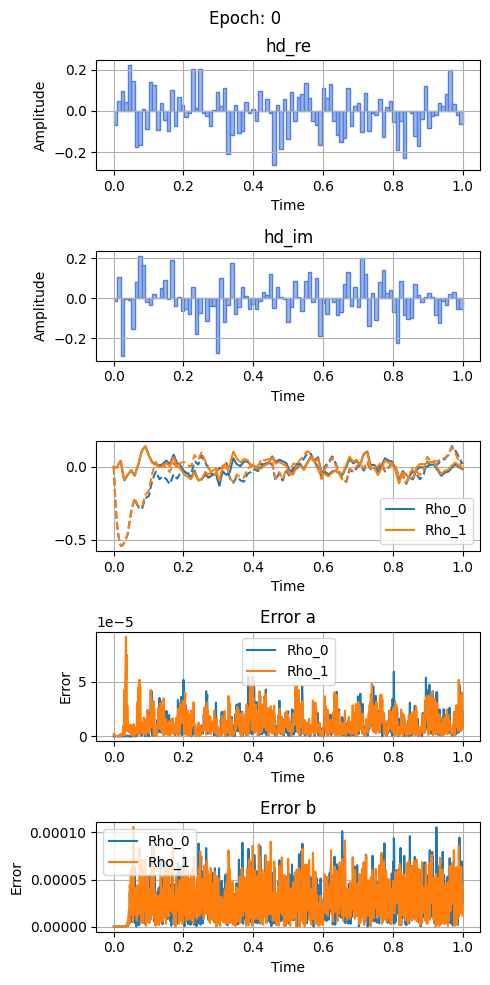

In [12]:
simu.plot_evolution();

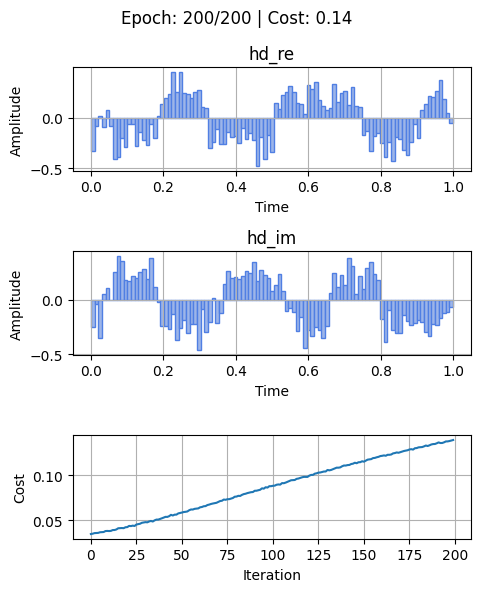

In [13]:
simu.optimize()

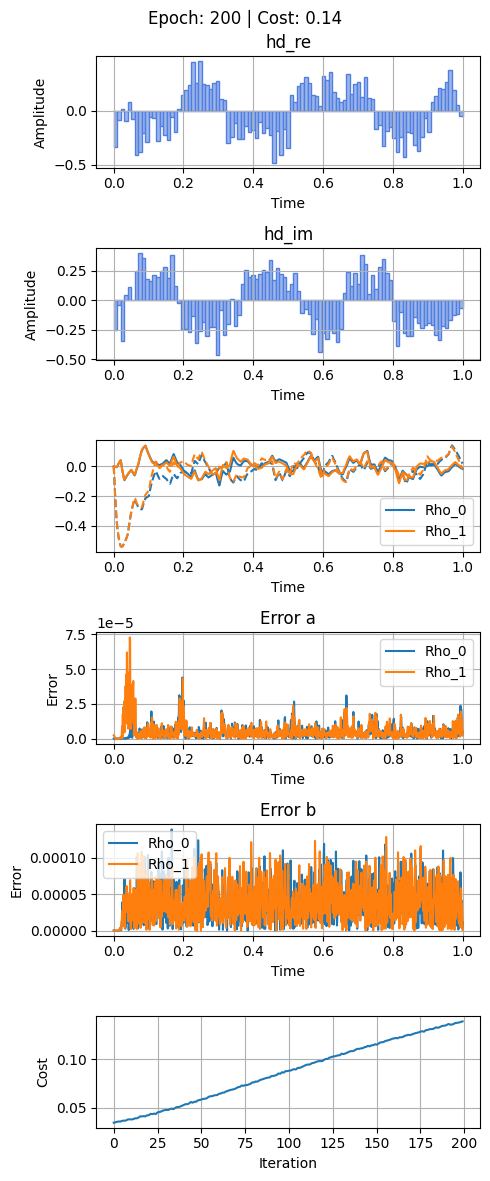

In [14]:
simu.plot_evolution();

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.35it/s]


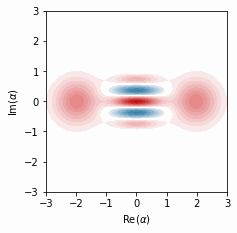

In [15]:
simu.plot_wigner_gif(ind_el=0, sub_system=0, xmax=3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.21it/s]


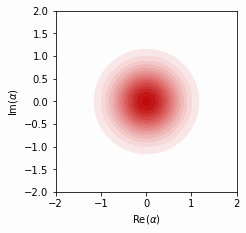

In [16]:
simu.plot_wigner_gif(ind_el=1, sub_system=1, xmax=2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.76it/s]


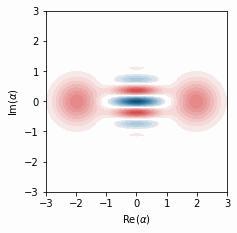

In [17]:
simu.plot_wigner_gif(ind_el=1, sub_system=0, xmax=3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.02it/s]


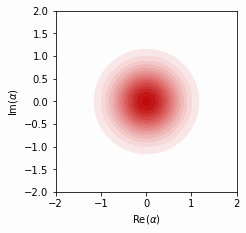

In [18]:
simu.plot_wigner_gif(ind_el=1, sub_system=1, xmax=2)